In [16]:
1*2

2

In [17]:
import itertools
import torch
import torch.nn.functional as F
import numpy as np

In [18]:
n_devices = torch.cuda.device_count()
output_device = torch.device('cuda:0')
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 2 GPUs.


In [19]:
alpha = 4
l = 8
alphabet = list(range(alpha))

In [37]:
seqs = list(itertools.product(alphabet, repeat=l))
seqs = torch.tensor(seqs).to(output_device)

In [42]:
seqs1h = torch.flatten(F.one_hot(seqs), start_dim=1).to(output_device)

In [43]:
x1 = seqs1h[:1000]
x2 = seqs1h[1000:2000]

In [45]:
masks = torch.mul(torch.unsqueeze(x1, 0), torch.unsqueeze(x2, 1))

In [46]:
masks.shape

torch.Size([1000, 1000, 32])

In [85]:
ps = torch.softmax(-torch.rand([l, alpha]), axis=1)

In [59]:
# prob no mutation at time 1
q = 1 - 1/l

In [87]:
odds = torch.tensor([q**t/(1 - q**t) for t in range(1, l+1)])

In [88]:
rates = odds.unsqueeze(1).unsqueeze(-1)  + torch.unsqueeze(ps, 0)
rates = rates/ps
rates = rates.to(output_device)
rates = torch.flatten(rates, start_dim=1)

In [89]:
rates.shape

torch.Size([8, 32])

In [83]:
masks.shape

torch.Size([1000, 1000, 32])

In [117]:
out = torch.mul(masks.unsqueeze(2), rates)

out[out==0.] = 1.

out.shape

torch.Size([1000, 1000, 8, 32])

In [118]:
powers_nz = torch.prod(out, -1)
power_0 = F.relu(torch.sum(masks, -1) - l + 1)
powers = torch.cat([power_0.unsqueeze(-1), powers_nz], dim=-1)


In [119]:
powers.shape

torch.Size([1000, 1000, 9])

In [108]:
weights = F.softmax(torch.randn(8)).to(output_device)

/scratch/local/46264634/ipykernel_54431/1816814007.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = F.softmax(torch.randn(8)).to(output_device)


In [81]:
# construct Wks
torch.sum(torch.mul(powers, weights), -1)

tensor([[1.9903e+05, 8.1533e+03, 8.1533e+03,  ..., 1.3488e+08, 1.3488e+08,
         1.3488e+08],
        [8.1533e+03, 1.7821e+05, 8.1533e+03,  ..., 3.2790e+09, 1.3488e+08,
         1.3488e+08],
        [8.1533e+03, 8.1533e+03, 3.0613e+05,  ..., 1.3488e+08, 5.6442e+09,
         1.3488e+08],
        ...,
        [5.7072e+03, 1.2455e+05, 5.7072e+03,  ..., 2.6539e+06, 1.1432e+05,
         1.1432e+05],
        [5.7072e+03, 5.7072e+03, 2.1395e+05,  ..., 1.1432e+05, 4.5643e+06,
         1.1432e+05],
        [5.7072e+03, 5.7072e+03, 5.7072e+03,  ..., 1.1432e+05, 1.1432e+05,
         2.8883e+06]], device='cuda:0')

In [132]:
scaling_factors = np.array([(1 - q**t)**l for t in range(l+1)])
scaling_factors[0] = 1
eigvals = np.array([[np.exp(-k*t) for t in range(l+1)] for k in range(l+1)])
eigvals = eigvals*scaling_factors

In [133]:
t = 1

In [134]:
scaling_factors[t]*np.array([np.exp(-k*t) for k in range(l+1)])

array([5.96046448e-08, 2.19273234e-08, 8.06661148e-09, 2.96754052e-09,
       1.09169715e-09, 4.01612937e-10, 1.47745143e-10, 5.43524006e-11,
       1.99951308e-11])

In [135]:
eigvals[:, 1]

array([5.96046448e-08, 2.19273234e-08, 8.06661148e-09, 2.96754052e-09,
       1.09169715e-09, 4.01612937e-10, 1.47745143e-10, 5.43524006e-11,
       1.99951308e-11])

In [218]:
coeffs = np.linalg.inv(eigvals)
coeffs = torch.tensor(coeffs, dtype=torch.float32).to(output_device)

### Kernel

In [14]:
import gpytorch
from gpytorch import settings
from gpytorch.constraints import Positive
from gpytorch.lazy import LazyEvaluatedKernelTensor, ZeroLazyTensor, delazify, lazify
from gpytorch.models import exact_prediction_strategies
from gpytorch.module import Module
from gpytorch.utils.broadcasting import _mul_broadcast_shape

In [15]:
odds = torch.tensor([q**t/(1 - q**t) for t in range(1, l+1)]).to(output_device)

In [16]:
from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan

class SkewKernel(gpytorch.kernels.Kernel):
    """Diploid kernel"""

    is_stationary = True

    # We will register the parameter when initializing the kernel
    def __init__(self, alpha, l, odds,
                log_lda_prior=None, log_lda_constraint=None, 
                log_p_prior=None, log_p_constraint=None,
                **kwargs):
        super().__init__(**kwargs)

        # register the raw parameter
        self.register_parameter(
          name='raw_log_p', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, l, alpha))
        )

        self.register_parameter(
          name='raw_log_lda', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, l+1))
        )

        # set the parameter constraint to be positive, when nothing is specified
        if log_lda_constraint is None:
          log_lda_constraint = LessThan(upper_bound=0.)

        if log_p_constraint is None:
          log_p_constraint = LessThan(upper_bound=0.)

        # register the constraint
        self.register_constraint("raw_log_lda", log_lda_constraint)
        self.register_constraint("raw_log_p", log_p_constraint)


    # now set up the 'actual' paramter
    @property
    def log_lda(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_log_lda_constraint.transform(self.raw_log_lda)

    @property
    def log_p(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_log_p_constraint.transform(self.raw_log_p)

    @log_lda.setter
    def log_lda(self, value):
      return self._set_log_lda(value)

    @log_p.setter
    def log_p(self, value):
      return self._set_log_p(value)


    def forward(self, x1, x2, **params):
        # construct masks used for calculate rates
        masks = torch.mul(torch.unsqueeze(x1, 0), torch.unsqueeze(x2, 1))
        ps = torch.softmax(self.log_p, axis=1)

        rates = odds.unsqueeze(1).unsqueeze(-1) + torch.unsqueeze(ps, 0)
        rates = rates/ps
        rates = rates.to(output_device)

        out = torch.mul(masks.unsqueeze(2), rates)
        out = torch.flatten(out, start_dim=3)

        out[out==0.] = 1.

        powers_nz = torch.prod(out, -1)
        power_0 = F.relu(torch.sum(torch.flatten(masks, start_dim=-2), -1) - l + 1)
        powers = torch.cat([power_0.unsqueeze(-1), powers_nz], dim=-1)

        weights = torch.matmul(coeffs.to(output_device), torch.exp(self.log_lda))

        return torch.sum(torch.mul(powers, weights), -1)

In [482]:
kernel = SkewKernel(alpha, l, odds)
kernel = kernel.to(output_device)

In [483]:
kernel.raw_log_lda = torch.nn.Parameter(torch.cat((torch.tensor([-100.]), -torch.arange(l))).to(output_device))

In [491]:
torch.arange(l+1).to(output_device)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')

In [497]:
kernel.raw_log_lda = torch.nn.Parameter(-1.*torch.arange(l+1).to(output_device))

In [537]:
ker = kernel.mask(x1, x1)

In [538]:
ker

tensor([[8.3926e+18, 2.8939e+17, 2.8939e+17,  ..., 4.0888e+11, 4.0888e+11,
         4.0888e+11],
        [2.8939e+17, 8.3926e+18, 2.8939e+17,  ..., 1.1862e+13, 4.0888e+11,
         4.0888e+11],
        [2.8939e+17, 2.8939e+17, 8.3926e+18,  ..., 4.0888e+11, 1.1862e+13,
         4.0888e+11],
        ...,
        [4.0888e+11, 1.1862e+13, 4.0888e+11,  ..., 8.3926e+18, 2.8939e+17,
         2.8939e+17],
        [4.0888e+11, 4.0888e+11, 1.1862e+13,  ..., 2.8939e+17, 8.3926e+18,
         2.8939e+17],
        [4.0888e+11, 4.0888e+11, 4.0888e+11,  ..., 2.8939e+17, 2.8939e+17,
         8.3926e+18]], device='cuda:0', grad_fn=<SumBackward1>)

In [539]:
rho = np.flip(ker.unique().detach().cpu().numpy())

In [540]:
# rho is exponential
np.roll(rho, 1)/rho

array([4.8719198e-08, 2.9000614e+01, 2.9001265e+01, 2.9002600e+01,
       2.9005327e+01, 2.9010887e+01], dtype=float32)

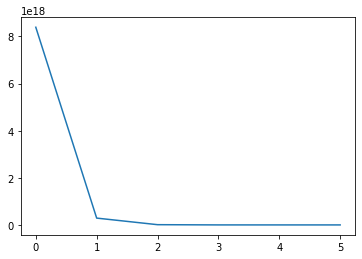

In [541]:
from matplotlib import pyplot as plt
plt.plot(rho)

In [488]:
weights = torch.zeros(l+1).to(output_device)

In [514]:
!wget https://raw.githubusercontent.com/davidmccandlish/vcregression/master/vcregression/data/Smn1/smn1data.csv

--2022-08-25 14:44:46--  https://raw.githubusercontent.com/davidmccandlish/vcregression/master/vcregression/data/Smn1/smn1data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1156484 (1.1M) [text/plain]
Saving to: ‘smn1data.csv’

100%[======================================>] 1,156,484   --.-K/s   in 0.08s   

2022-08-25 14:44:46 (13.5 MB/s) - ‘smn1data.csv’ saved [1156484/1156484]



In [518]:
import pandas as pd
dat = pd.read_csv("smn1data.csv", header=None)

In [524]:
dat = dat.rename(columns={0:"seq", 1:"psi", 2:"std"})

In [530]:
dat.seq

0        GAACAUGU
1        AUUUGUGG
2        CGAUACGU
3        CAUCUUUU
4        AGGCCAAG
           ...   
24581    UUAUAUCC
24582    GGGCCCCG
24583    CGGUCGAU
24584    AUUUGAAG
24585    UUUUCUUC
Name: seq, Length: 24586, dtype: object

In [ ]:
from torchtext.data.utils import get_tokenizer
corpus = ["The cat sat the mat", "The dog ate my homework"]
tokenizer = get_tokenizer("basic_english")
tokens = [tokenizer(doc) for doc in corpus]

In [533]:
import tokenize

In [535]:
tokenize.tokenize("ABC")

TypeError: 'str' object is not callable